# Outliers and Kriging

Outliers may affect our analysis and the final interpolation results. In this tutorial, we learn about their influence on the final model and compare interpolation errors for different scenarios. In one set of experiments we clean outliers directly from a dataset, and in another set of experiments we remove outliers from semivariogram.

We can remove too high or too low values at the preprocessing stage (check part 2 of the tutorial) or remove outliers directly from the variogram point cloud (part 4).

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging (basics)
  - outliers (statistical concept)
  - variogram point cloud
- **Package**:
  - `TheoreticalVariogram`
  - `ExperimentalVariogram`
  - `interpolate_points()`
  - `VariogramCloud()`
- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Prepare data
2. Analyze distribution and remove potential outliers
3. Create the Variogram Point Cloud models
4. Remove outliers from the point cloud
5. Compare performance of Ordinary Kriging on data with different cleaning levels

## 1. Prepare data

In [96]:
import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pyinterpolate import VariogramCloud, build_theoretical_variogram
from pyinterpolate import interpolate_points

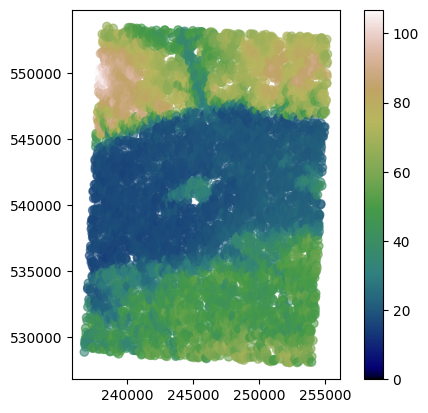

In [97]:
# Load DEM data

df = pd.read_csv(
    '../data/dem.csv'
)
# Populate geometry column and set CRS

dem_geometry = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs='epsg:4326')
dem = gpd.GeoDataFrame(df, geometry=dem_geometry)

# Transform crs to metric values
dem.to_crs(epsg=2180, inplace=True)
dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

In [98]:
train = dem.sample(n=int(0.5*len(dem)))
test = dem.loc[~dem.index.isin(train.index)]

## 2. Analyze data distribution and remove potential outliers

We will inspect all values in the train set to determine if our dataset contains outliers. In the beginning, we plot data distribution using violin plot, this kind of visulization will show the general distribution.

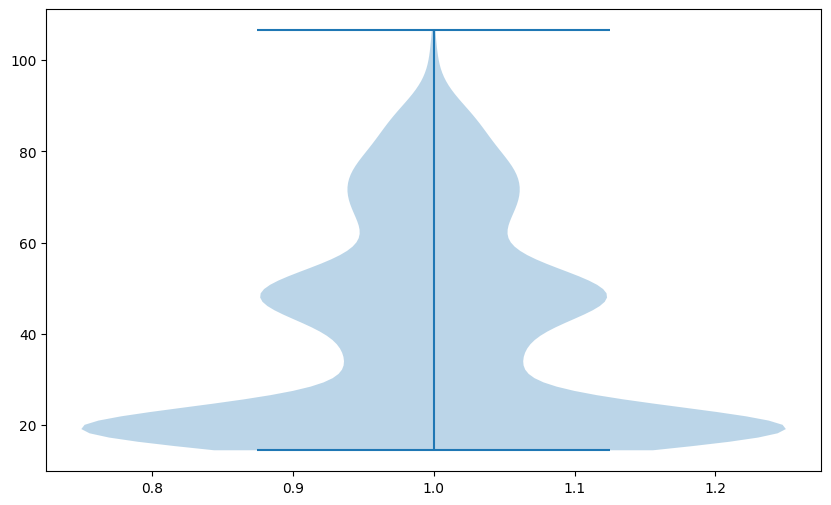

In [99]:
plt.figure(figsize=(10, 6))
plt.violinplot(train['dem'])
plt.show()

> **Note**: Your plot may differ from the tutorial's. Why is that? Because we take a random sample of 2% of values, and after each iteration, the algorithm takes different points for the analysis.

**Clarification**

Investigation of the plot tells us that our data is:

- grouped around the lowest values, and most of the values are below 50 meters
- has (probably) two different distributions mixed, which can be a sign that the Digital Elevation Model covers multiple different types of elevation. One is grouped around 20 meters, the next roughly 50 meters

Violin plot is suitable for the distribution analysis. Finding outliers in this plot may be challenging because we see mostly distributions. We should change a plot type to understand if outliers exist in a dataset. The excellent choice is the boxplot:

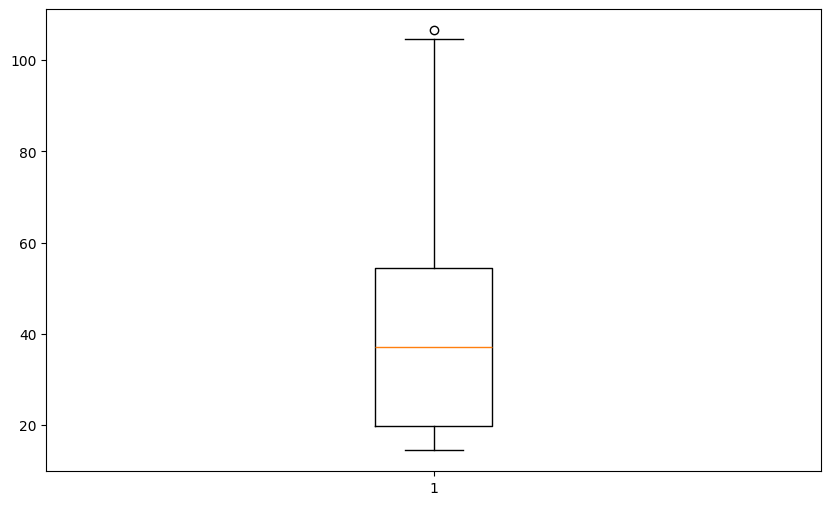

In [100]:
plt.figure(figsize=(10, 6))
plt.boxplot(train['dem'])
plt.show()

**Boxplot** is a handy data visualization tool. Let's analyze this plot from the bottom up to the top.

> **Note**: Boxplot represents values sorted in ascending order and their statistical properties: quartiles, median, and outliers.

- The bottom whisker (horizontal line) represents the lower range of values in our dataset
- The box lower line is the first quartile (*Q1*) of data or, in other words, 25% of values of our dataset are below this point
- The middle line is the median (*Q2*) of our dataset
- The upper line is the third quartile (*Q3*) of a data or, in other words, 75% of values are below this point,
- The top whisker represents the upper range of values in our dataset.
- Individual points (if they exist, then we see them as points below the bottom whisker or above the top whisker) are considered outliers. They could be outliers in the upper range as well as the lower range of our data. The significant distance between Q1 and the bottom whisker or between Q3 and the top whisker indicates potential outliers. Points below or above this distance are treated as outliers. The outlier distance is calculated as $weight * (Q3 - Q1)$  where we can manually set the `weight`, but other parameters are read from data.

We use this knowledge to remove outliers from the dataset. We will manually remove outliers from the data, assuming that outliers are placed one standard deviation from Q1 (down) and Q3 (up).

In [101]:
# Create training set without outliers

q1 = np.quantile(train['dem'], 0.25)
q3 = np.quantile(train['dem'], 0.75)

top_limit = q3 + (q3 - q1)

train_without_outliers = train[train['dem'] < top_limit]

In [102]:
train['dem'].describe()

count    3447.000000
mean       40.673435
std        22.148742
min        14.495489
25%        19.911645
50%        37.055336
75%        54.489574
max       106.547783
Name: dem, dtype: float64

In [103]:
train_without_outliers['dem'].describe()

count    3389.000000
mean       39.771834
std        21.219750
min        14.495489
25%        19.767307
50%        36.051571
75%        53.541000
max        89.060410
Name: dem, dtype: float64

**Clarification**

Mean and standard deviation of transformed dataset are lower, and the maximal value is different than in the raw training set. Does this transformation affect modeling? We will see in the next steps.

## 3. Create Variogram Clouds

Now, we are going one step further, and we will transform both datasets with- and without- outliers and calculate variogram point clouds. Then, we compare both clouds.

In [104]:
step_size = 1000  # meters
max_range = 10000  # meters

In [105]:
cloud_with = VariogramCloud(
    ds=train[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

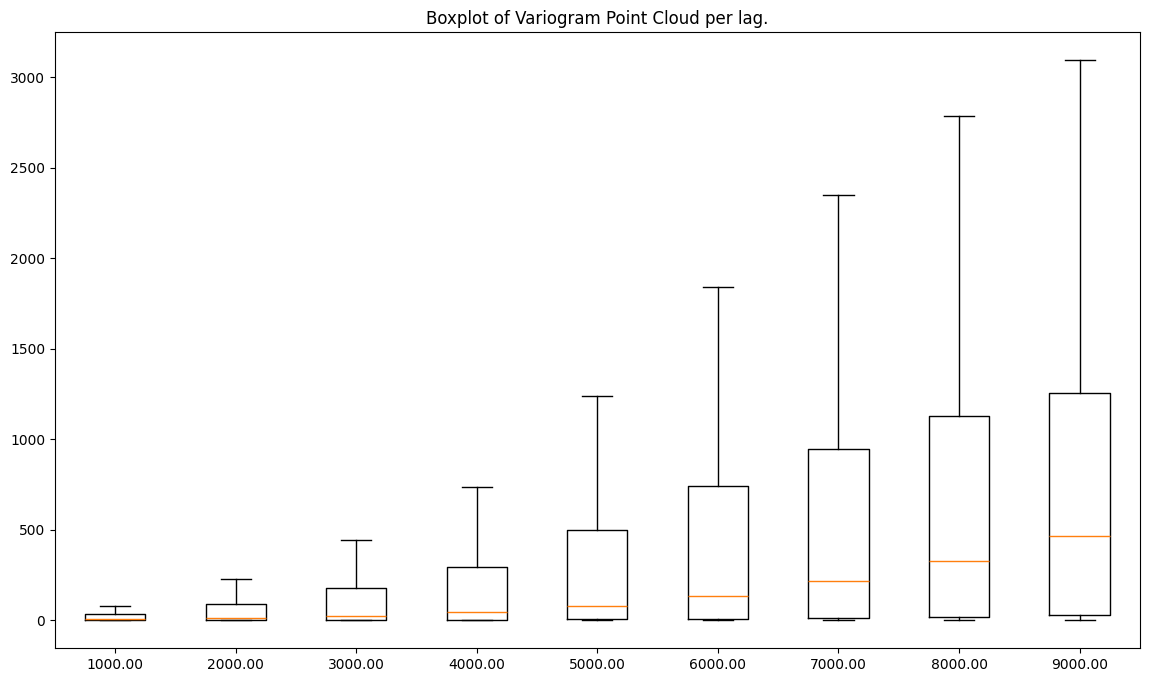

True

In [106]:
cloud_with.plot('box')

In [107]:
cloud_without = VariogramCloud(
    ds=train_without_outliers[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

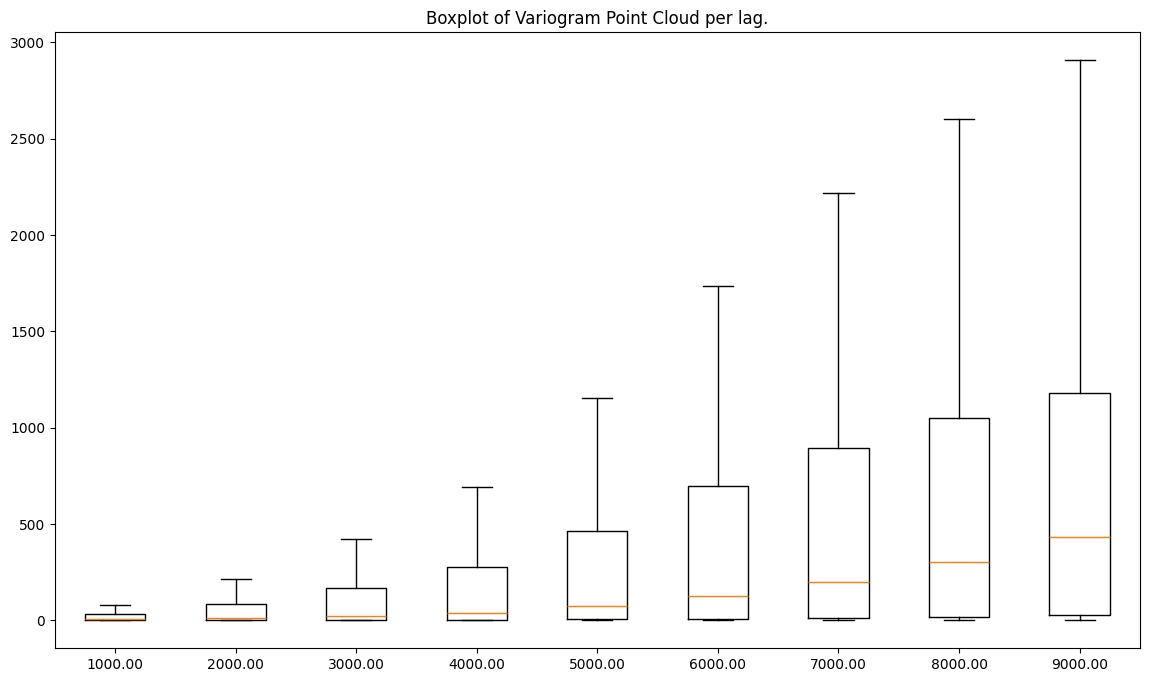

True

In [108]:
cloud_without.plot('box')

**Clarification**

The processed dataset has lower semivariances than the raw readings, and both variograms have a similar shape.

In the next cell, we will check a standard deviation of semivariances for each lag.

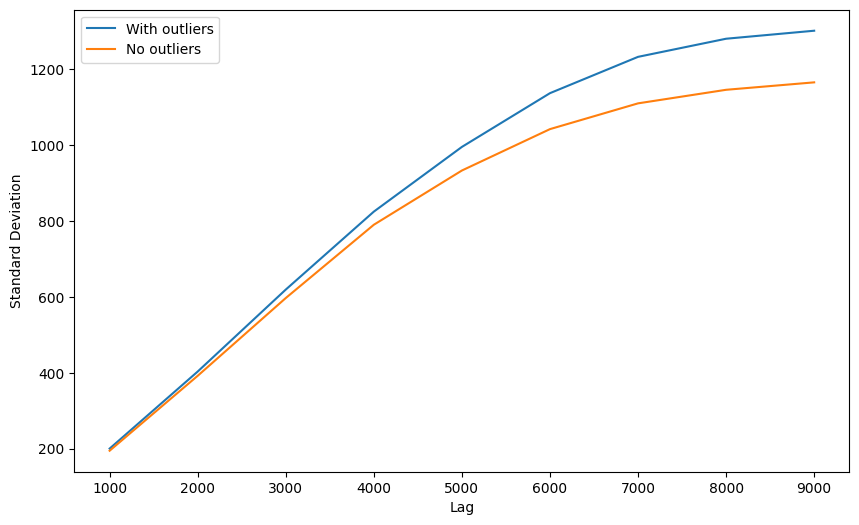

In [109]:
with_stats = cloud_with.describe()
without_stats = cloud_without.describe()

with_stds = []
without_stds = []
lags = []
for lag in with_stats:
    lags.append(lag)
    with_stds.append(with_stats[lag]['std'])
    without_stds.append(without_stats[lag]['std'])

plt.figure(figsize=(10, 6))
plt.plot(lags, with_stds)
plt.plot(lags, without_stds)
plt.legend(['With outliers', 'No outliers'])
plt.xlabel('Lag')
plt.ylabel('Standard Deviation')
plt.show()

**Clarification**

Data cleaning brings the best outcomes to more distant lags. Why? Because those lags group the largest sets of point pairs, and outlier influence is amplified by number of pairs with those outliers.

It doesn't mean that the bottom semivariogram is better, especially when we consider the fact, that closest bins are those most important. We should proceed with experiments.

## 4. Remove outliers from the point cloud

In this step, we will use `VariogramCloud` method `.remove_outliers()` to build two additional variogram point clouds from the raw and processed datasets.



In [110]:
cloud_with_rem = cloud_with.remove_outliers(
    method='zscore',
    z_lower_limit=-2,
    z_upper_limit=2,
    inplace=False
)

cloud_without_rem = cloud_without.remove_outliers(
    method='zscore',
    z_lower_limit=-2,
    z_upper_limit=2,
    inplace=False
)

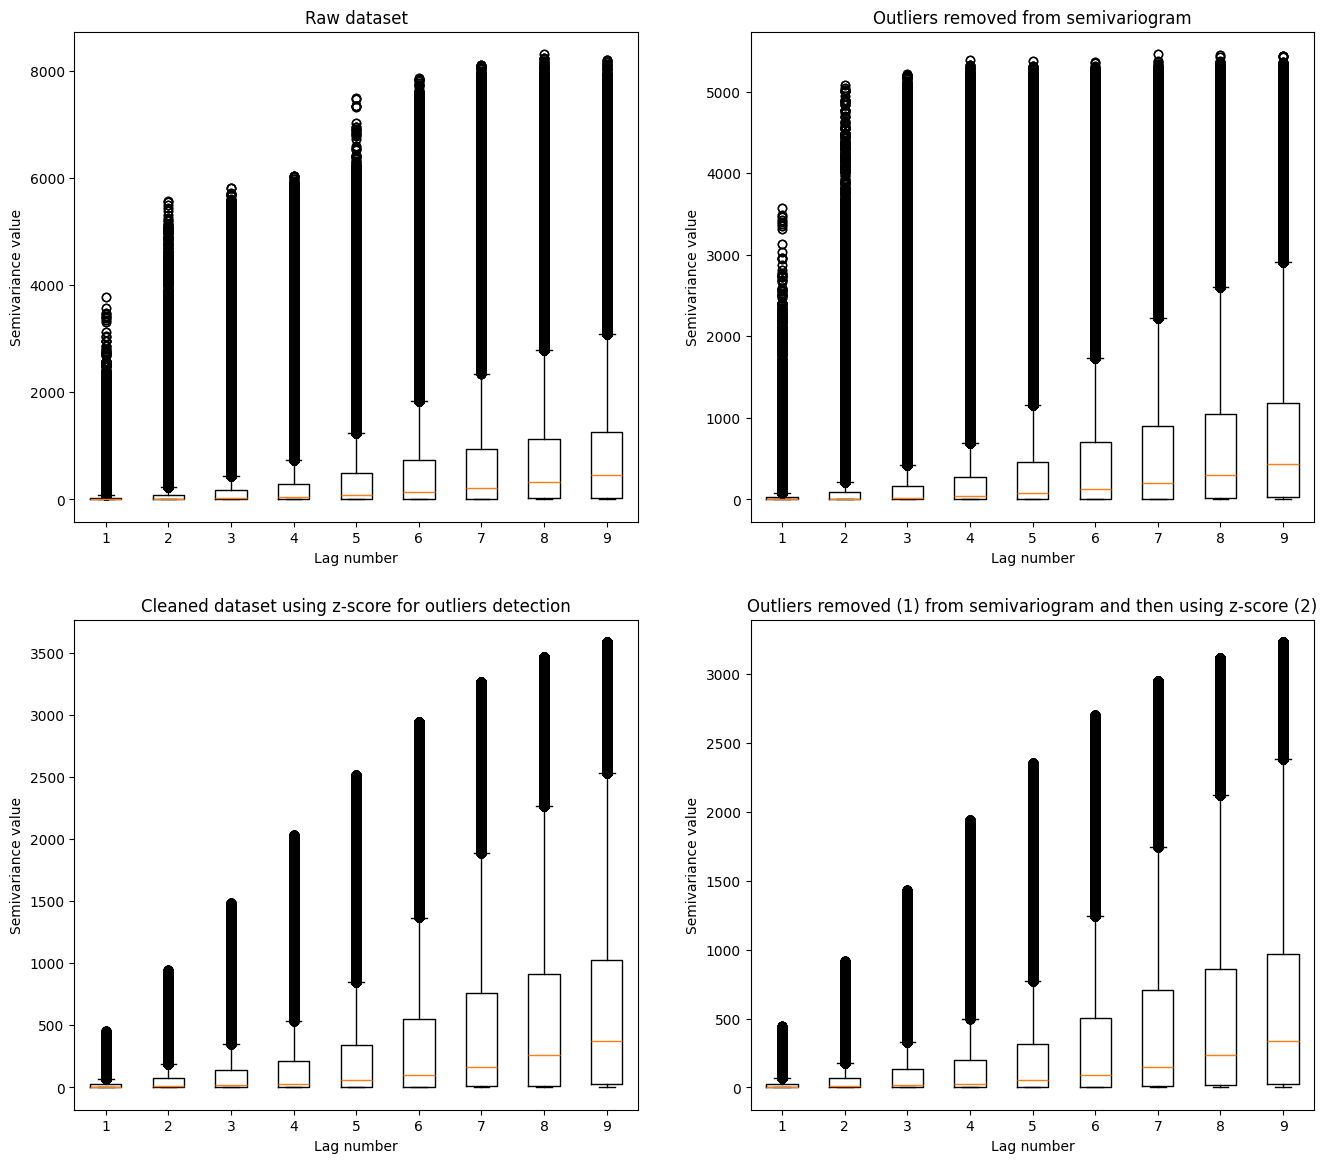

In [111]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

ax[0, 0].boxplot(list(cloud_with.semivariances.values()))
ax[0, 0].set_title('Raw dataset')
ax[0, 0].set_xlabel('Lag number')
ax[0, 0].set_ylabel('Semivariance value')

ax[0, 1].boxplot(list(cloud_without.semivariances.values()))
ax[0, 1].set_title('Outliers removed from semivariogram')
ax[0, 1].set_xlabel('Lag number')
ax[0, 1].set_ylabel('Semivariance value')

ax[1, 0].boxplot(list(cloud_with_rem.semivariances.values()))
ax[1, 0].set_title('Cleaned dataset using z-score for outliers detection')
ax[1, 0].set_xlabel('Lag number')
ax[1, 0].set_ylabel('Semivariance value')

ax[1, 1].boxplot(list(cloud_without_rem.semivariances.values()))
ax[1, 1].set_title('Outliers removed (1) from semivariogram and then using z-score (2)')
ax[1, 1].set_xlabel('Lag number')
ax[1, 1].set_ylabel('Semivariance value')

plt.show()

**Clarification**: Comparison of multiple variogram clouds could be challenging. We see that the largest semivariances are present in the raw data. Heavily processed data has the lowest number of outliers. The medians in each dataset are distributed over a similar pattern. How is it similar? We can check if we transform the variogram point cloud into the experimental semivariogram. `VariogramCloud` class has a method for it: `.average_semivariance()`. We use it and compare four plots of semivariances to gain more insight into the transformations.

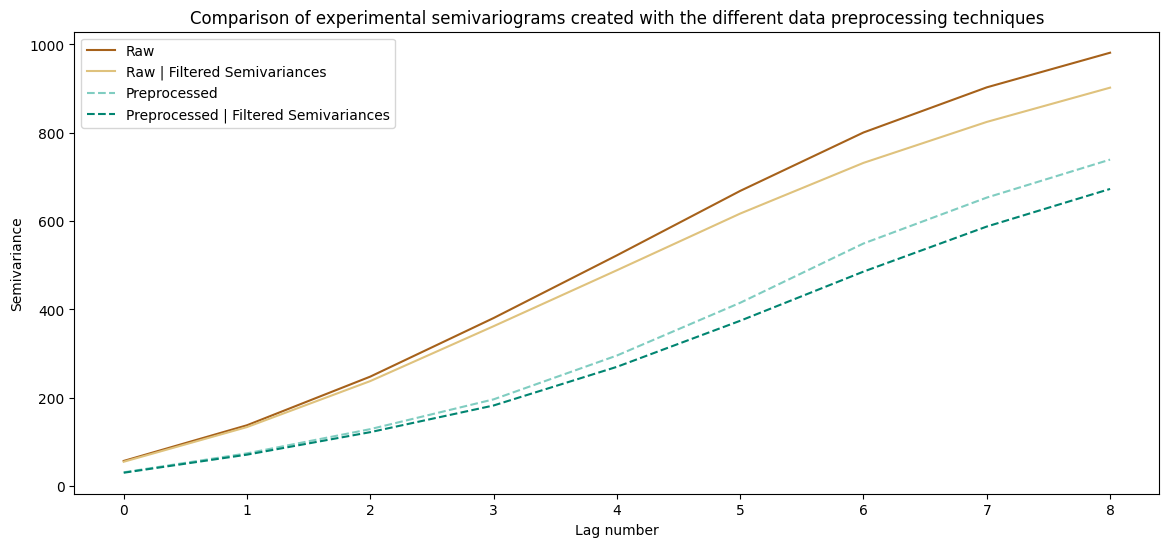

In [112]:
plt.figure(figsize=(14, 6))
plt.plot(cloud_with.average_semivariance()[:, 1], c='#a6611a')
plt.plot(cloud_without.average_semivariance()[:, 1], c='#dfc27d')
plt.plot(cloud_with_rem.average_semivariance()[:, 1], '--', c='#80cdc1')
plt.plot(cloud_without_rem.average_semivariance()[:, 1], '--', c='#018571')
plt.title('Comparison of experimental semivariograms created with the different data preprocessing techniques')
plt.ylabel('Semivariance')
plt.xlabel('Lag number')
plt.legend(['Raw', 'Raw | Filtered Semivariances', 'Preprocessed', 'Preprocessed | Filtered Semivariances'])
plt.show()

**Clarification**: An understanding of those plots is a challenging task. Let's divide reasoning into multiple points:

- Raw dataset and preprocessed raw dataset show a similar pattern. The differences are more pronounced for the distant lags than for the closest point pairs (there are more point pairs, thus those lags have greater chance having outlier values)
- Datasets with the cleaned variograms are different from the raw data. The absolute semivariance values per lag are smaller, and the semivariogram line is slightly different.
- The differences between semivariograms are primarily visible at larger distances, and differences are minor for the closest point pairs.
- Filtering semivariance sharply lowers the weights per lag, and removing outliers from the input data only slightly corrects the variogram.
- Both preprocessed and preprocessed and cleaned datasets are the same. Why? Probably after initial preprocessing step there are no outliers at all!

Let's check how different variograms work with the real-world data.

## 5. Kriging Models based on different variograms

In [113]:
# Fit different semivariogram models into prepared datasets and variograms

# Raw
raw_theo = build_theoretical_variogram(
    experimental_variogram=cloud_with.average_semivariance(),
    models_group='linear',
    nugget=0
)

# Raw with cleaned variogram
raw_theo_no_out = build_theoretical_variogram(
    experimental_variogram=cloud_without.average_semivariance(),
    models_group='linear',
    nugget=0
)

# Preprocessed
prep_theo = build_theoretical_variogram(
    experimental_variogram=cloud_with_rem.average_semivariance(),
    models_group='linear',
    nugget=0
)

# Preprocessed with cleaned variogram
prep_theo_no_out = build_theoretical_variogram(
    experimental_variogram=cloud_without_rem.average_semivariance(),
    models_group='linear',
    nugget=0
)

In [114]:
# Set Kriging models

unknown_locs = test['geometry'].to_numpy()

raw_interpolated = interpolate_points(
    theoretical_model=raw_theo,
    known_locations=train[['geometry', 'dem']],
    unknown_locations=unknown_locs,
    progress_bar=True
)

raw_no_interpolated = interpolate_points(
    theoretical_model=raw_theo_no_out,
    known_locations=train[['geometry', 'dem']],
    unknown_locations=unknown_locs,
    progress_bar=True
)

proc_raw_interpolated = interpolate_points(
    theoretical_model=prep_theo,
    known_locations=train[['geometry', 'dem']],
    unknown_locations=unknown_locs,
    progress_bar=True
)

proc_no_interpolated = interpolate_points(
    theoretical_model=prep_theo_no_out,
    known_locations=train[['geometry', 'dem']],
    unknown_locations=unknown_locs,
    progress_bar=True
)

100%|██████████| 3448/3448 [00:14<00:00, 233.77it/s]


In [115]:
# estimate deviations using squared error

results = test.copy()
results['raw'] = raw_interpolated[:, 0]
results['raw_variogram_filtering'] = raw_no_interpolated[:, 0]
results['point_cloud_filtered'] = proc_raw_interpolated[:, 0]
results['all_filtered'] = proc_no_interpolated[:, 0]


In [116]:
results['d-raw'] = (results['dem'] - results['raw'])**2
results['d-raw_variogram_filtering'] = (results['dem'] - results['raw_variogram_filtering'])**2
results['d-point_cloud_filtered'] = (results['dem'] - results['point_cloud_filtered'])**2
results['d-all_filtered'] = (results['dem'] - results['all_filtered'])**2

In [117]:
stats = results[
    [
        'd-raw',
        'd-raw_variogram_filtering',
        'd-point_cloud_filtered',
        'd-all_filtered'
    ]
].describe()

In [118]:
stats.loc[['mean', 'std', '50%', 'min', 'max']]

,d-raw,d-raw_variogram_filtering,d-point_cloud_filtered,d-all_filtered
mean,9.584068e+00,9.584068e+00,9.584068e+00,9.584068e+00
std,3.016640e+01,3.016640e+01,3.016640e+01,3.016640e+01
50%,9.422445e-01,9.422445e-01,9.422445e-01,9.422445e-01
min,2.448797e-08,2.448797e-08,2.448797e-08,2.448797e-08
max,4.800424e+02,4.800424e+02,4.800424e+02,4.800424e+02


The view of this table may be different each time you run this tutorial (and it is related to the training-test division process). In some cases, you may get better results for the cleaned dataset; for others, results will be better for raw data. That's why we should always have a validation set to compare different scenarios. The other idea is to use all the models and create a distribution of predictions and errors per point - we can use it later for decisions.

> NOTE: The example in this tutorial is Digital Elevation Model from Copernicus Land Monitoring Services. Looking at rather uniform results, you shouldn't get the impression that raw data preprocessing and filtering are useless. There are cases where the sensor may produce unreliable and biased results, such as a satellite camera's saturated pixel. Removing it with the specific noise-filtering algorithm before the variogram fitting might give you a better model.

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-05-17 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |